# 概要
体重データが4年分たまったので可視化してみた。
ついでに、ジムに各年度どのくらい行っているかを調べるためにfoursquareの履歴も調査

# 運動を何回したか
foursquareのデータからトレ体とジムにチェックインしたデータを取ってきて、回数を調査。

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup

sns.set(style='whitegrid', font='Osaka')

In [2]:
def visit_count(file):
    soup = BeautifulSoup(open(file), "html5lib")
    return pd.Series([d.get_text().split(',')[1].split()[0]
     for d in soup.select('.checkinListContent > p.metadata > a')])\
                  .value_counts().sort_index()

foursquareのデータは履歴でトレ体およびジムをそれぞれ調べて、htmlをダウンロードした。

In [3]:
toretai = visit_count('History.html')
gym = visit_count('History_gym.html')

,トレ体,ジム,合計
2012,34,0,34
2013,34,0,34
2014,62,0,62
2015,2,21,23
2016,4,170,174
2017,1,19,20


/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


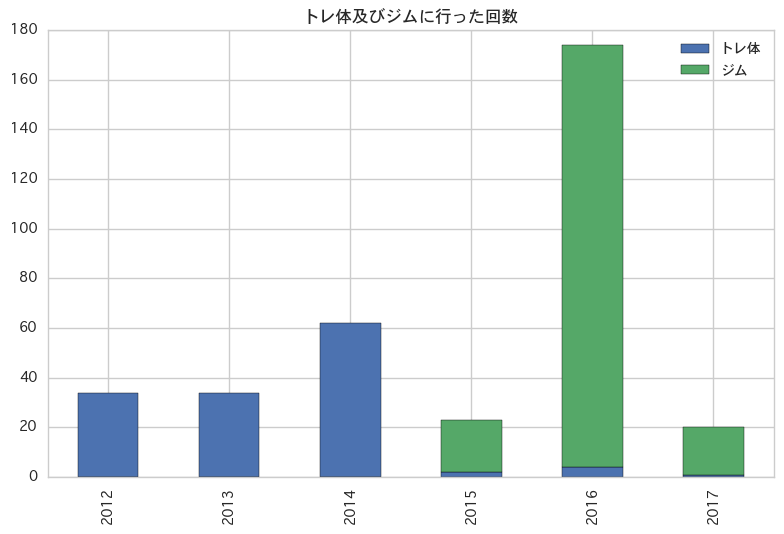

In [4]:
gyms = pd.concat([toretai, gym], axis=1).fillna(0)
gyms.columns = ['トレ体', 'ジム']
gyms['ジム'] = gyms['ジム'].astype(int)
gyms['合計'] = gyms.sum(1)
gyms[['トレ体', 'ジム']].plot(kind='bar', stacked=True)
plt.title('トレ体及びジムに行った回数')
gyms

# 体重データの調査

体重データはgoogle spreadsheetで管理しているものをcsv exportした。

| 日付 | 体重 | 年 |
|:-----------:|:------------:|:------------:|
| 2016-01-01       |  70 | 2016 |

年がついているのは、spreadsheetで処理していた内容の都合。

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


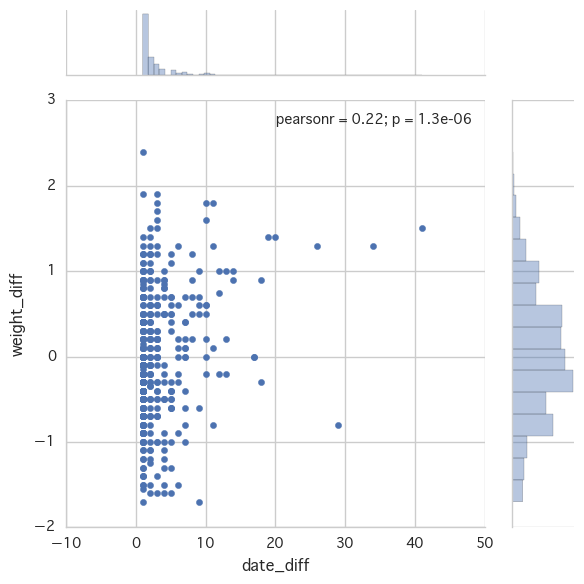

In [5]:
df = pd.read_csv('weight.csv', header=None,
                 names=['DATE', 'WEIGHT', 'YEAR'],
                 parse_dates=['DATE'])
df['date_diff'] = df.DATE.diff().dropna().apply(lambda x: x.days)
df['weight_diff'] = df.WEIGHT.diff()
df['weight_per_date'] = df['weight_diff'] / df['date_diff']
plt.figure()
sns.jointplot('date_diff', 'weight_diff', df)

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


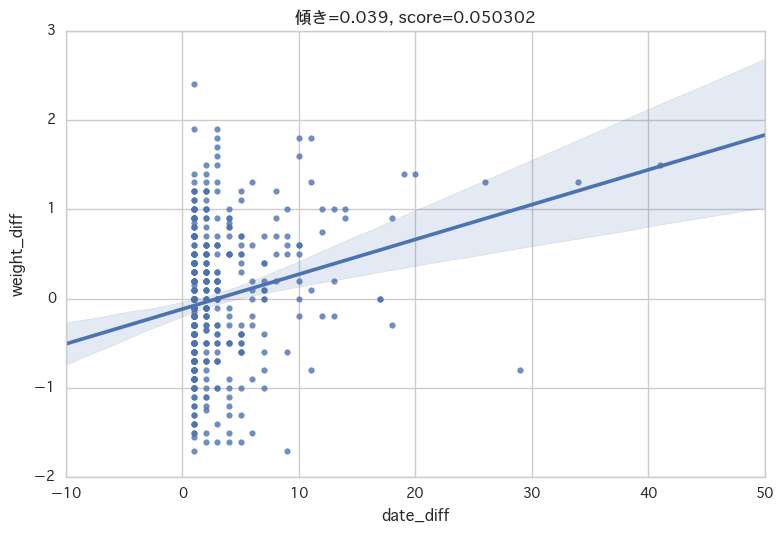

In [6]:
reg = LinearRegression()
dropped = df.dropna()
reg.fit(np.vstack(dropped.date_diff), dropped.weight_diff)
score = reg.score(np.vstack(dropped.date_diff), dropped.weight_diff)
plt.figure()
sns.regplot('date_diff', 'weight_diff', df)
plt.title('傾き=%0.3f, score=%f' % (reg.coef_[0], score))

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


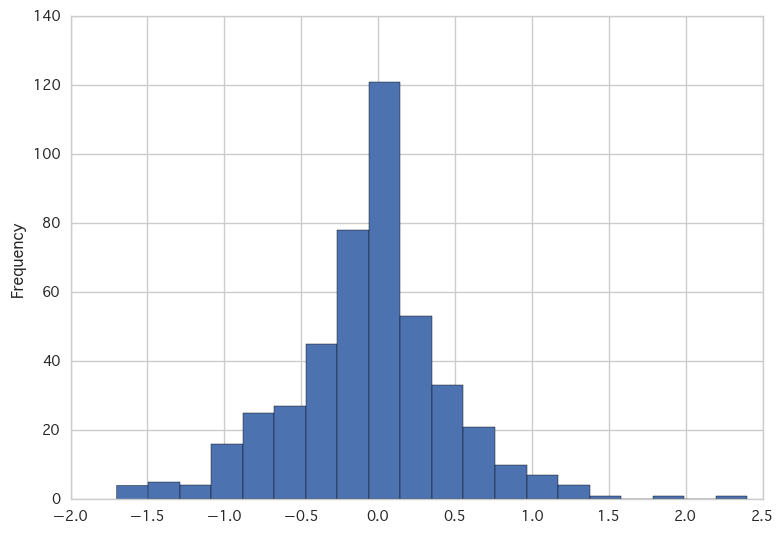

In [7]:
df.weight_per_date.plot.hist(bins=20)

## 年ごとの比較
年ごとの比較のうまいやり方がわからなかったので、無理やり処理している。

In [8]:
df['converted_date'] = df.apply(lambda x:
                                x.DATE + pd.DateOffset((2016 - x.YEAR)*365), axis=1)

In [9]:
yearly = df.drop_duplicates(subset=['YEAR', 'converted_date'], keep='last')\
           .pivot(index='converted_date', columns='YEAR', values='WEIGHT')
yearly = yearly.rename(index=(lambda x: x.strftime("%Y-%m-%d")))

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


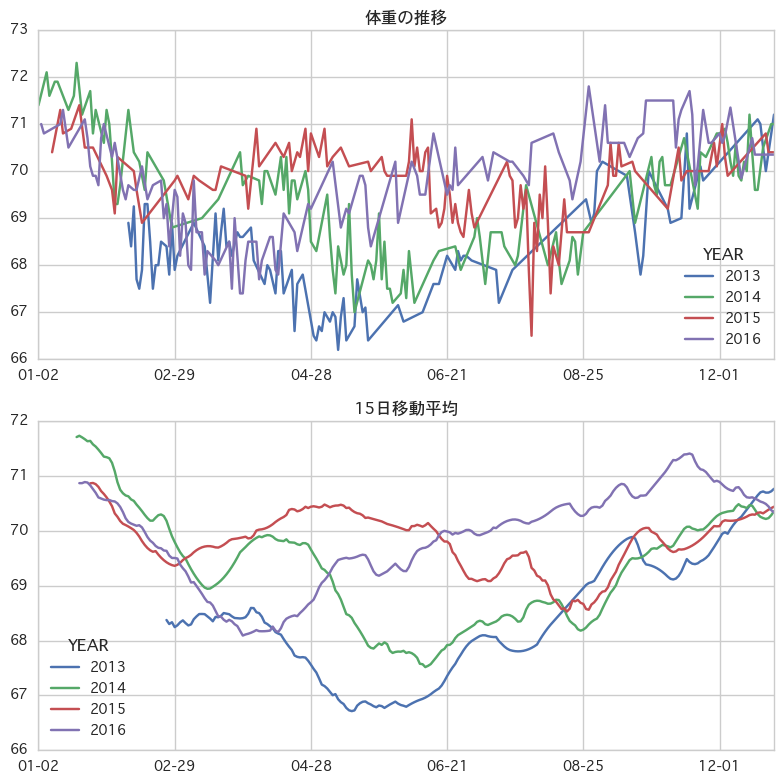

In [10]:
new_idx = pd.date_range('2016-01-01', '2016-03-31').map(lambda x: x.strftime("%Y-%m-%d"))
yearly.reindex(new_idx)
yearly.index.name = ''
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
axes[0].set_title('体重の推移')
yearly.rename(index=(lambda x: x[5:])).interpolate().plot(ax=axes[0])
window = 15
axes[1].set_title('%d日移動平均' % window)
yearly.rename(index=(lambda x: x[5:])).interpolate()\
      .rolling(window=window).mean().plot(ax=axes[1])